# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

## Задание 1

В данном задании вам необходимо реализовать алгоритм кластеризации [Partition Around Medoids](http://algowiki-project.org/ru/%D0%A3%D1%87%D0%B0%D1%81%D1%82%D0%BD%D0%B8%D0%BA:Denemmy/Partitioning_Around_Medoids_%28%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%29).  
  
Два возможных варианта реализации:  
  
### Функция
  
Нужно написать функцию, которая принимает на вход несколько параметров и возвращает также несколько значений.  
  
Параметры функции:
- **data:** данные в виде dataframe или матрицы (аналогично функциям и методам, которые рассматривали на практике);
- **k:** число центров (кластеров);
- **metric:** расстояние между объектами (те же, что поддерживает функция `pdist()`);
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.

Возвращаемые значения:  
- **inertia:** итоговое значение целевой функции;
- **medoids:** центры кластеров - индексы объектов данных, которые являются центрами;
- **labels:** метки кластеров для каждого объекта.
  
### Класс  
  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).
  
Параметры: 
- **k:** число центров (кластеров);
- **metric:** расстояние между объектами (те же, что поддерживает функция `pdist()`);
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Методы:  
- **fit():** метод для выполнения кластеризации.  
    Аргументы метода:  
    - **data:** данные в виде dataframe или матрицы
  
Атрибуты:  
- **inertia_:** итоговое значение целевой функции;
- **medoids_:** центры кластеров - индексы объектов данных, которые являются центрами;
- **labels_:** метки кластеров для каждого объекта.  
   
<br>  
**Note 1:** Параметры `max_iter` и `tol` должны иметь дефолтные значения.  
**Note 2:** Функции для вычисления расстояний самим реализовывать не нужно, используйте `pdist()`.  
  
<br>  
Также необходимо написать документацию к функции/методу: описать формат входных данных (параметров) и возвращаемых значений, особенности работы функции и детали реализации алгоритма. В качестве образца можно взять документацию к функциям/методам, которые рассматривали на занятиях.  
  
Наивная реализация алгоритма будет работать довольно медленно - это нормально. Будет плюсом (но не является обязательным), если вы попытаетесь оптимизировать ваш код. Можете указать все ваши решения для оптимизации в документации.   

In [1]:
import pandas as pd

data = pd.read_csv('Data.txt', sep=' ').drop(columns=['Place', 'Long', 'Lat'])

In [15]:
def k_medoids(data, k, metric, max_iter=10, tol=5):  # gets data - DataFrame or numpy.array instance with the data or distances, metric - metric to measure distances between objects as string, k - number of medoids as int, max_iter - max number of redefinitions of medoids as int, tol - min changing level of target fun as float
    
    '''KMedoids clustering implemention'''
    
    from scipy.spatial.distance import pdist, squareform  # required modules
    from itertools import permutations
    import numpy as np
    import pandas as pd
    
    # Build phase    
    if isinstance(data, pd.core.frame.DataFrame):
        data = squareform(pdist(data, metric=metric))  # creating distance matrix from DataFrame instance
        
    num_obj = data.shape[0]
    ind_obj = np.random.randint(0, num_obj - 1, num_obj)  # object indexing
    medoids = np.random.choice(ind_obj, k, replace=False) # initial medoids
    updated_medoids = None
    clusters = None
    target_fun = None
    target_fun_updated = None
    
    # Get nearest obj to medoid (helper fun)
    def set_nearest():
        nonlocal data, medoids, clusters
        
        grouping_dict = dict.fromkeys(medoids)  # making a dict with medoids as keys and empty lists as values
        
        for key in grouping_dict.keys():
            grouping_dict[key] = list()
            
        for ind_obj, distances in enumerate(data):  # assign objects to the nearest medoids
            min_dist_to_k = min(distances[medoids])
            
            for med, dst in zip(medoids, distances[medoids]):
                if dst == min_dist_to_k:
                    grouping_dict[med].append(ind_obj)
                    break
                    
        clusters = grouping_dict
    
    # Change medoid to optimal (helper fun)
    def redefine_medoid():
        nonlocal data, clusters, updated_medoids
        
        new_medoids = list()
        
        for clst in clusters.values():  # considering clusters separately
            while len(clst) == 0:  # case if all objects are nearer to other medoids (choose and find nearest again)
                medoids = np.random.choice(ind_obj, k, replace=False)
                get_nearest()
                
            obj_with_dist = dict.fromkeys(clst, 0)  # make a dict with objects from cluster as keys and distances as values (now there are 0s)
            
            for obj, neighbor in permutations(clst, 2):  # summing of distances from current object to all other ones
                obj_with_dist[obj] += data[obj, neighbor]
            
            min_sum_dist = min(obj_with_dist.values())
            
            for key, value in obj_with_dist.items():  # searching for the central object (where the sum of distances is min)
                if value == min_sum_dist:
                    new_medoids.append(key)
                    break
            
        updated_medoids = np.array(new_medoids)  # change medoids
    
    # Calculating summ of distnaces for every object to appropriate medoid
    def target_realiz():
        nonlocal data, clusters, medoids
        
        sum_dist = 0
        
        for key, clst_obj in clusters.items():
            sum_dist += np.sum(data[key][clst_obj])
            
        return sum_dist
        
    # Swap phase
    set_nearest()
    target_fun = target_realiz()  # prerealization of swap phase
    redefine_medoid()
    
    medoids = updated_medoids
        
    set_nearest()
    target_fun_updated = target_realiz()
    redefine_medoid()
    
    
    counter = 1
    
    while all([not np.array_equal(medoids, updated_medoids), counter != max_iter, abs(target_fun - target_fun_updated) >= tol]):  # while medoids doesnt't stop changing and number of iterations is not max and changing of target fun >= tol we continue to recount them
        target_fun = target_fun_updated
        medoids = updated_medoids
        
        set_nearest()
        target_fun_updated = target_realiz()  # realization of swap phase
        redefine_medoid()
        counter += 1
        
    print('Number of iterations to stop changing medoids is', counter)
    
    # Labeling of object (helper fun)
    def labeling():
        gen_list = list()
        
        for num, clst in enumerate(clusters.values()):  # labeling of objects with relevant indexes
            gen_list += zip(np.full(len(clst), num), clst)
        
        return gen_list
    
    return {'inertia': target_fun_updated, 'medoids': updated_medoids, 'labels': labeling()}  # return final values of target fun as float, updated medoids as numpy.array, labels for every object as list of tuples with label and index of object
    

In [5]:
clust_k_medoids = k_medoids(data, 5, 'euclidean', 18, 0)

Number of iterations to stop changing medoids is 9


In [6]:
# Final value of target fun
clust_k_medoids['inertia']

44642569.76530192

In [7]:
# Indexes of medoids
clust_k_medoids['medoids']

array([322,  97,  76,  90, 255])

In [8]:
# Labesls of objects (1st - label, 2nd - index of object)
clust_k_medoids['labels']

[(0, 1),
 (0, 4),
 (0, 6),
 (0, 23),
 (0, 24),
 (0, 27),
 (0, 47),
 (0, 55),
 (0, 59),
 (0, 63),
 (0, 71),
 (0, 91),
 (0, 103),
 (0, 114),
 (0, 118),
 (0, 121),
 (0, 126),
 (0, 129),
 (0, 130),
 (0, 141),
 (0, 144),
 (0, 145),
 (0, 151),
 (0, 155),
 (0, 161),
 (0, 164),
 (0, 167),
 (0, 175),
 (0, 197),
 (0, 209),
 (0, 222),
 (0, 224),
 (0, 226),
 (0, 242),
 (0, 246),
 (0, 258),
 (0, 276),
 (0, 287),
 (0, 293),
 (0, 294),
 (0, 299),
 (0, 302),
 (0, 303),
 (0, 317),
 (0, 319),
 (0, 322),
 (0, 324),
 (0, 327),
 (1, 7),
 (1, 14),
 (1, 16),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 29),
 (1, 30),
 (1, 36),
 (1, 50),
 (1, 60),
 (1, 69),
 (1, 72),
 (1, 74),
 (1, 79),
 (1, 81),
 (1, 84),
 (1, 88),
 (1, 89),
 (1, 95),
 (1, 96),
 (1, 97),
 (1, 100),
 (1, 108),
 (1, 112),
 (1, 128),
 (1, 135),
 (1, 140),
 (1, 146),
 (1, 147),
 (1, 149),
 (1, 154),
 (1, 162),
 (1, 163),
 (1, 169),
 (1, 172),
 (1, 177),
 (1, 180),
 (1, 181),
 (1, 183),
 (1, 184),
 (1, 187),
 (1, 189),
 (1, 198),
 (1, 201),
 (1, 210),
 (1,

# Задание 2

В рамках данной лабораторной работы вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

In [16]:
import pandas as pd

In [17]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

In [18]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

,Attribute,Description
0,Place,"City, state (postal code)"
1,Climate & Terrain,"Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days."
2,Housing,"Utility bills, property taxes, mortgage payments."
3,Health Care & Environment,"Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution."
4,Crime,"Violent crime rate, property crime rate."
5,Transportation,"Daily commute, public transportation, Interstate highways, air service, passenger rail service."
6,Education,"Pupil/teacher ratio in the public K-12 system, effort index in K-12, accademic options in higher education."
7,The Arts,"Museums, fine arts and public radio stations, public television stations, universities offering a degree or degrees in the arts, symphony orchestras, theatres, opera companies, dance companies, public libraries."
8,Recreation,"Good restaurants, public golf courses, certified lanes for tenpin bowling, movie theatres, zoos, aquariums, family theme parks, sanctioned automobile race tracks, pari-mutuel betting attractions, major- and minor- league professional sports teams, NCAA Division I football and basketball teams, miles of ocean or Great Lakes coastline, inland water, national forests, national parks, or national wildlife refuges, Consolidated Metropolitan Statistical Area access."
9,Economics,"Average household income adjusted for taxes and living costs, income growth, job growth."


### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [22]:
data = pd.read_csv('Data.txt', sep=' ')
data

,Place,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Long,Lat,Pop
0,"Abilene,TX",521,6200,237,923,4031,2757,996,1405,7633,-99.6890,32.5590,110932
1,"Akron,OH",575,8138,1656,886,4883,2438,5564,2632,4350,-81.5180,41.0850,660328
2,"Albany,GA",468,7339,618,970,2531,2560,237,859,5250,-84.1580,31.5750,112402
3,"Albany-Schenectady-Troy,NY",476,7908,1431,610,6883,3399,4655,1617,5864,-73.7983,42.7327,835880
4,"Albuquerque,NM",659,8393,1853,1483,6558,3026,4496,2612,5727,-106.6500,35.0830,419700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,"Worcester,MA",562,8715,1805,680,3643,3299,1784,910,5040,-71.7950,42.2720,402918
325,"Yakima,WA",535,6440,317,1106,3731,2491,996,2140,4986,-120.5130,46.5950,172508
326,"York,PA",540,8371,713,440,2267,2903,1022,842,4946,-76.7280,39.9600,381255
327,"Youngstown-Warren,OH",570,7021,1097,938,3374,2920,2797,1327,3894,-80.7290,41.1700,531350


<br>  
### Задания: 

&nbsp;&nbsp;&nbsp;0. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.

In [23]:
from sklearn import preprocessing
import numpy as np
from scipy import stats

# nans
print(data.isnull().sum())

# preprocessing normalization
data = data.drop(columns=['Place', 'Long', 'Lat'])
data = pd.DataFrame(preprocessing.scale(data), columns=data.columns)
data = np.round(data, 2)

# noises and dublicates
data_stats = list()
for feat in data.columns:
    data_stats += list(data[np.abs(stats.zscore(data[feat])) > 3].index)
data = data.iloc[list(set(range(len(data))) - set(data_stats))]
data = data.reset_index()
data

Place          0
Climate        0
HousingCost    0
HlthCare       0
Crime          0
Transp         0
Educ           0
Arts           0
Recreat        0
Econ           0
Long           0
Lat            0
Pop            0
dtype: int64


,index,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Pop
0,0,-0.15,-0.90,-0.95,-0.11,-0.12,-0.18,-0.46,-0.55,1.95,-0.46
1,1,0.30,-0.09,0.47,-0.21,0.46,-1.18,0.52,0.97,-1.09,0.15
2,2,-0.59,-0.42,-0.57,0.03,-1.16,-0.80,-0.63,-1.22,-0.25,-0.46
3,3,-0.52,-0.18,0.24,-0.98,1.84,1.82,0.32,-0.28,0.31,0.35
4,4,1.00,0.02,0.67,1.46,1.62,0.66,0.29,0.95,0.19,-0.11
...,...,...,...,...,...,...,...,...,...,...,...
299,324,0.19,0.15,0.62,-0.79,-0.39,1.51,-0.29,-1.16,-0.45,-0.13
300,325,-0.03,-0.80,-0.87,0.41,-0.33,-1.01,-0.46,0.36,-0.50,-0.39
301,326,0.01,0.01,-0.47,-1.46,-1.34,0.28,-0.46,-1.24,-0.54,-0.16
302,327,0.26,-0.56,-0.09,-0.06,-0.58,0.33,-0.08,-0.64,-1.51,0.01


1. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы.  
<br>  
2. Выполните кластеризацию методом dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.  
<br>  
3. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  
<br>  
4. Выполните кластеризацию методом PAM. Используйте расстояния между объектами, определенные в пункте (1). Определите наилучшее (на ваш взгляд) число кластеров.  
Используйте реализацию алгоритма из Задания 1.  
<br>  
5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.  
<br>  
6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиения объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).  
<br>  
7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.  
<br>  
8. Оцените, как полученные кластеры распределены географически. (Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?

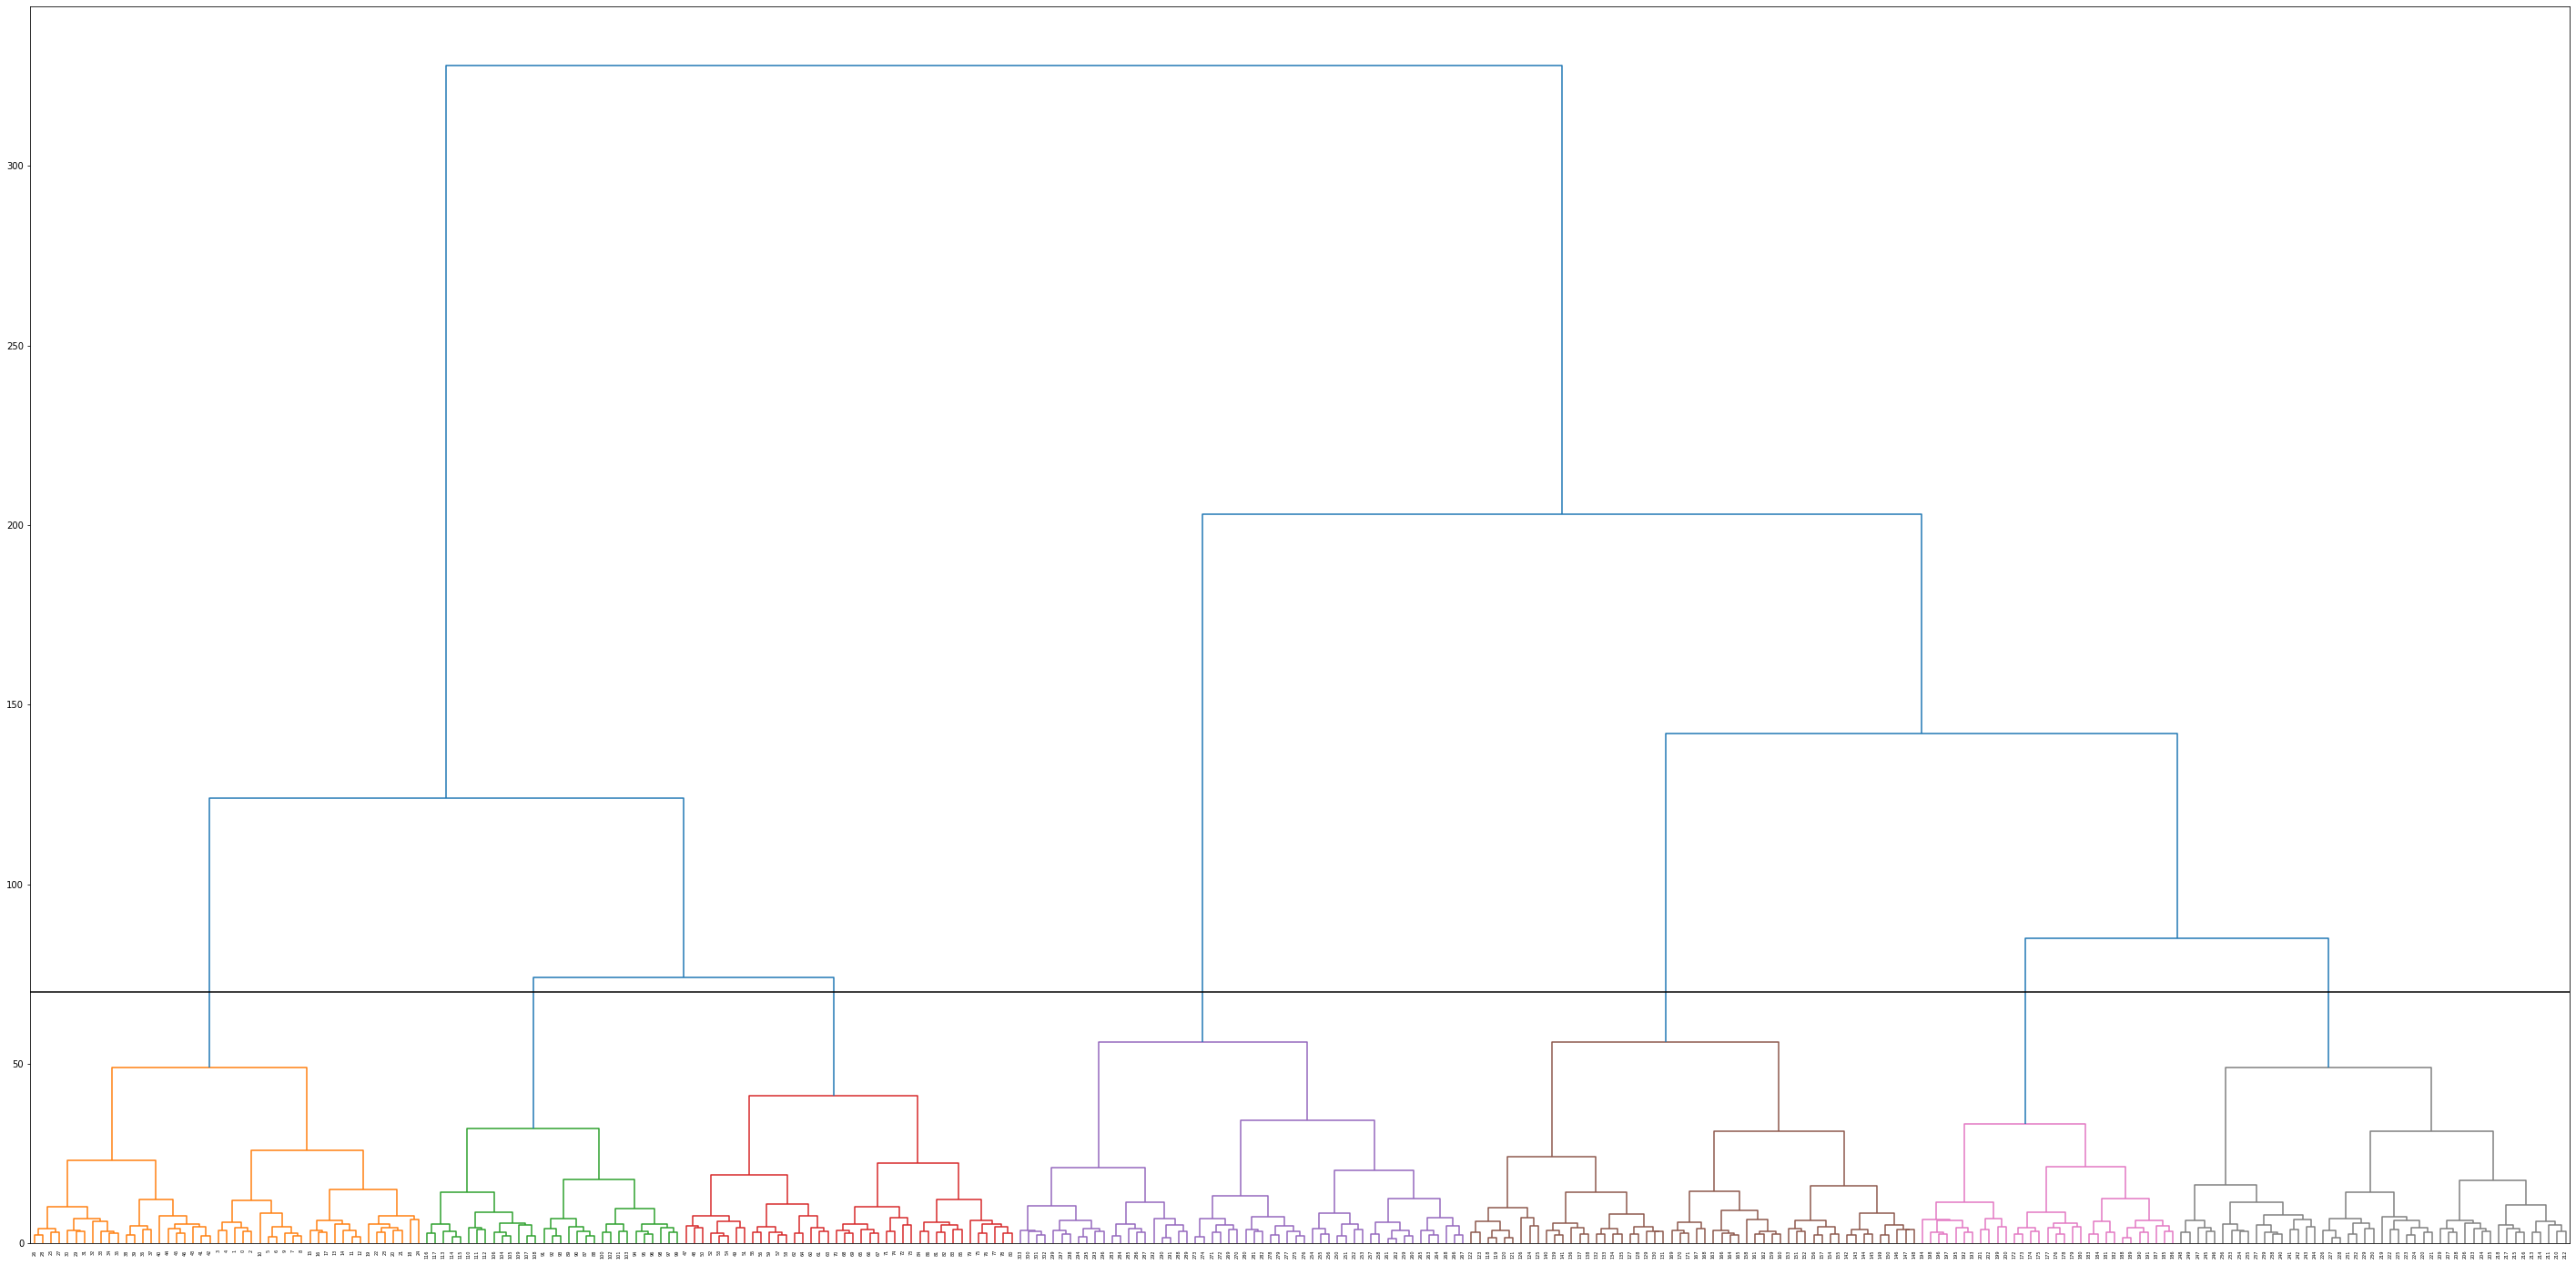

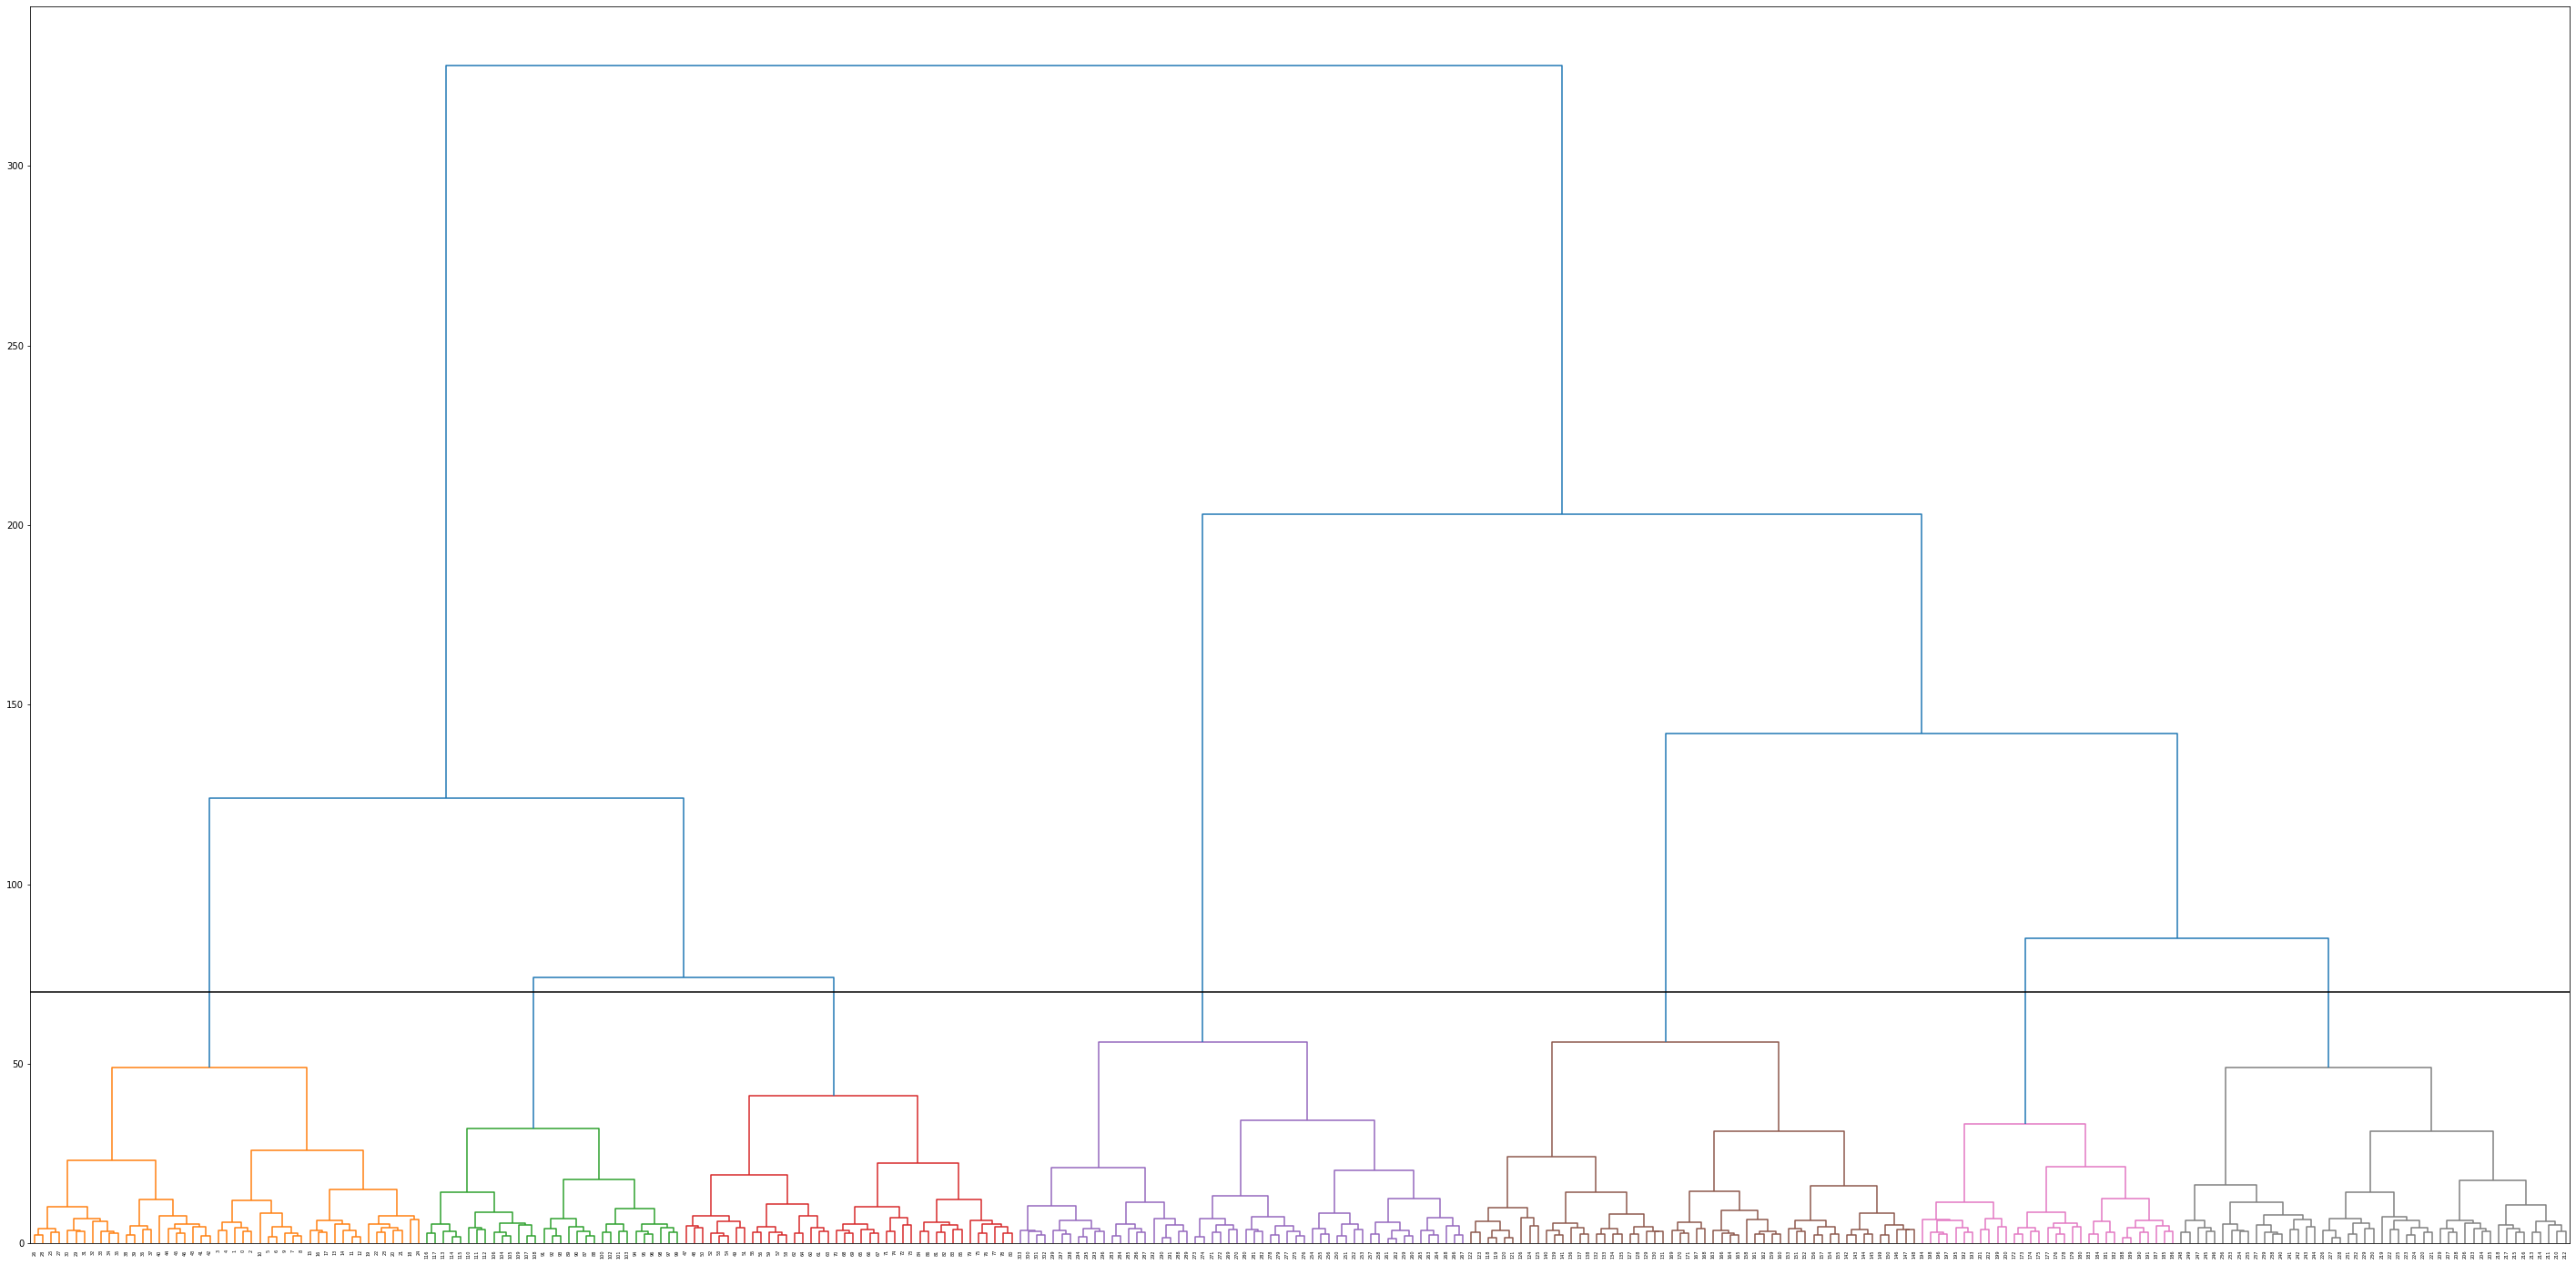

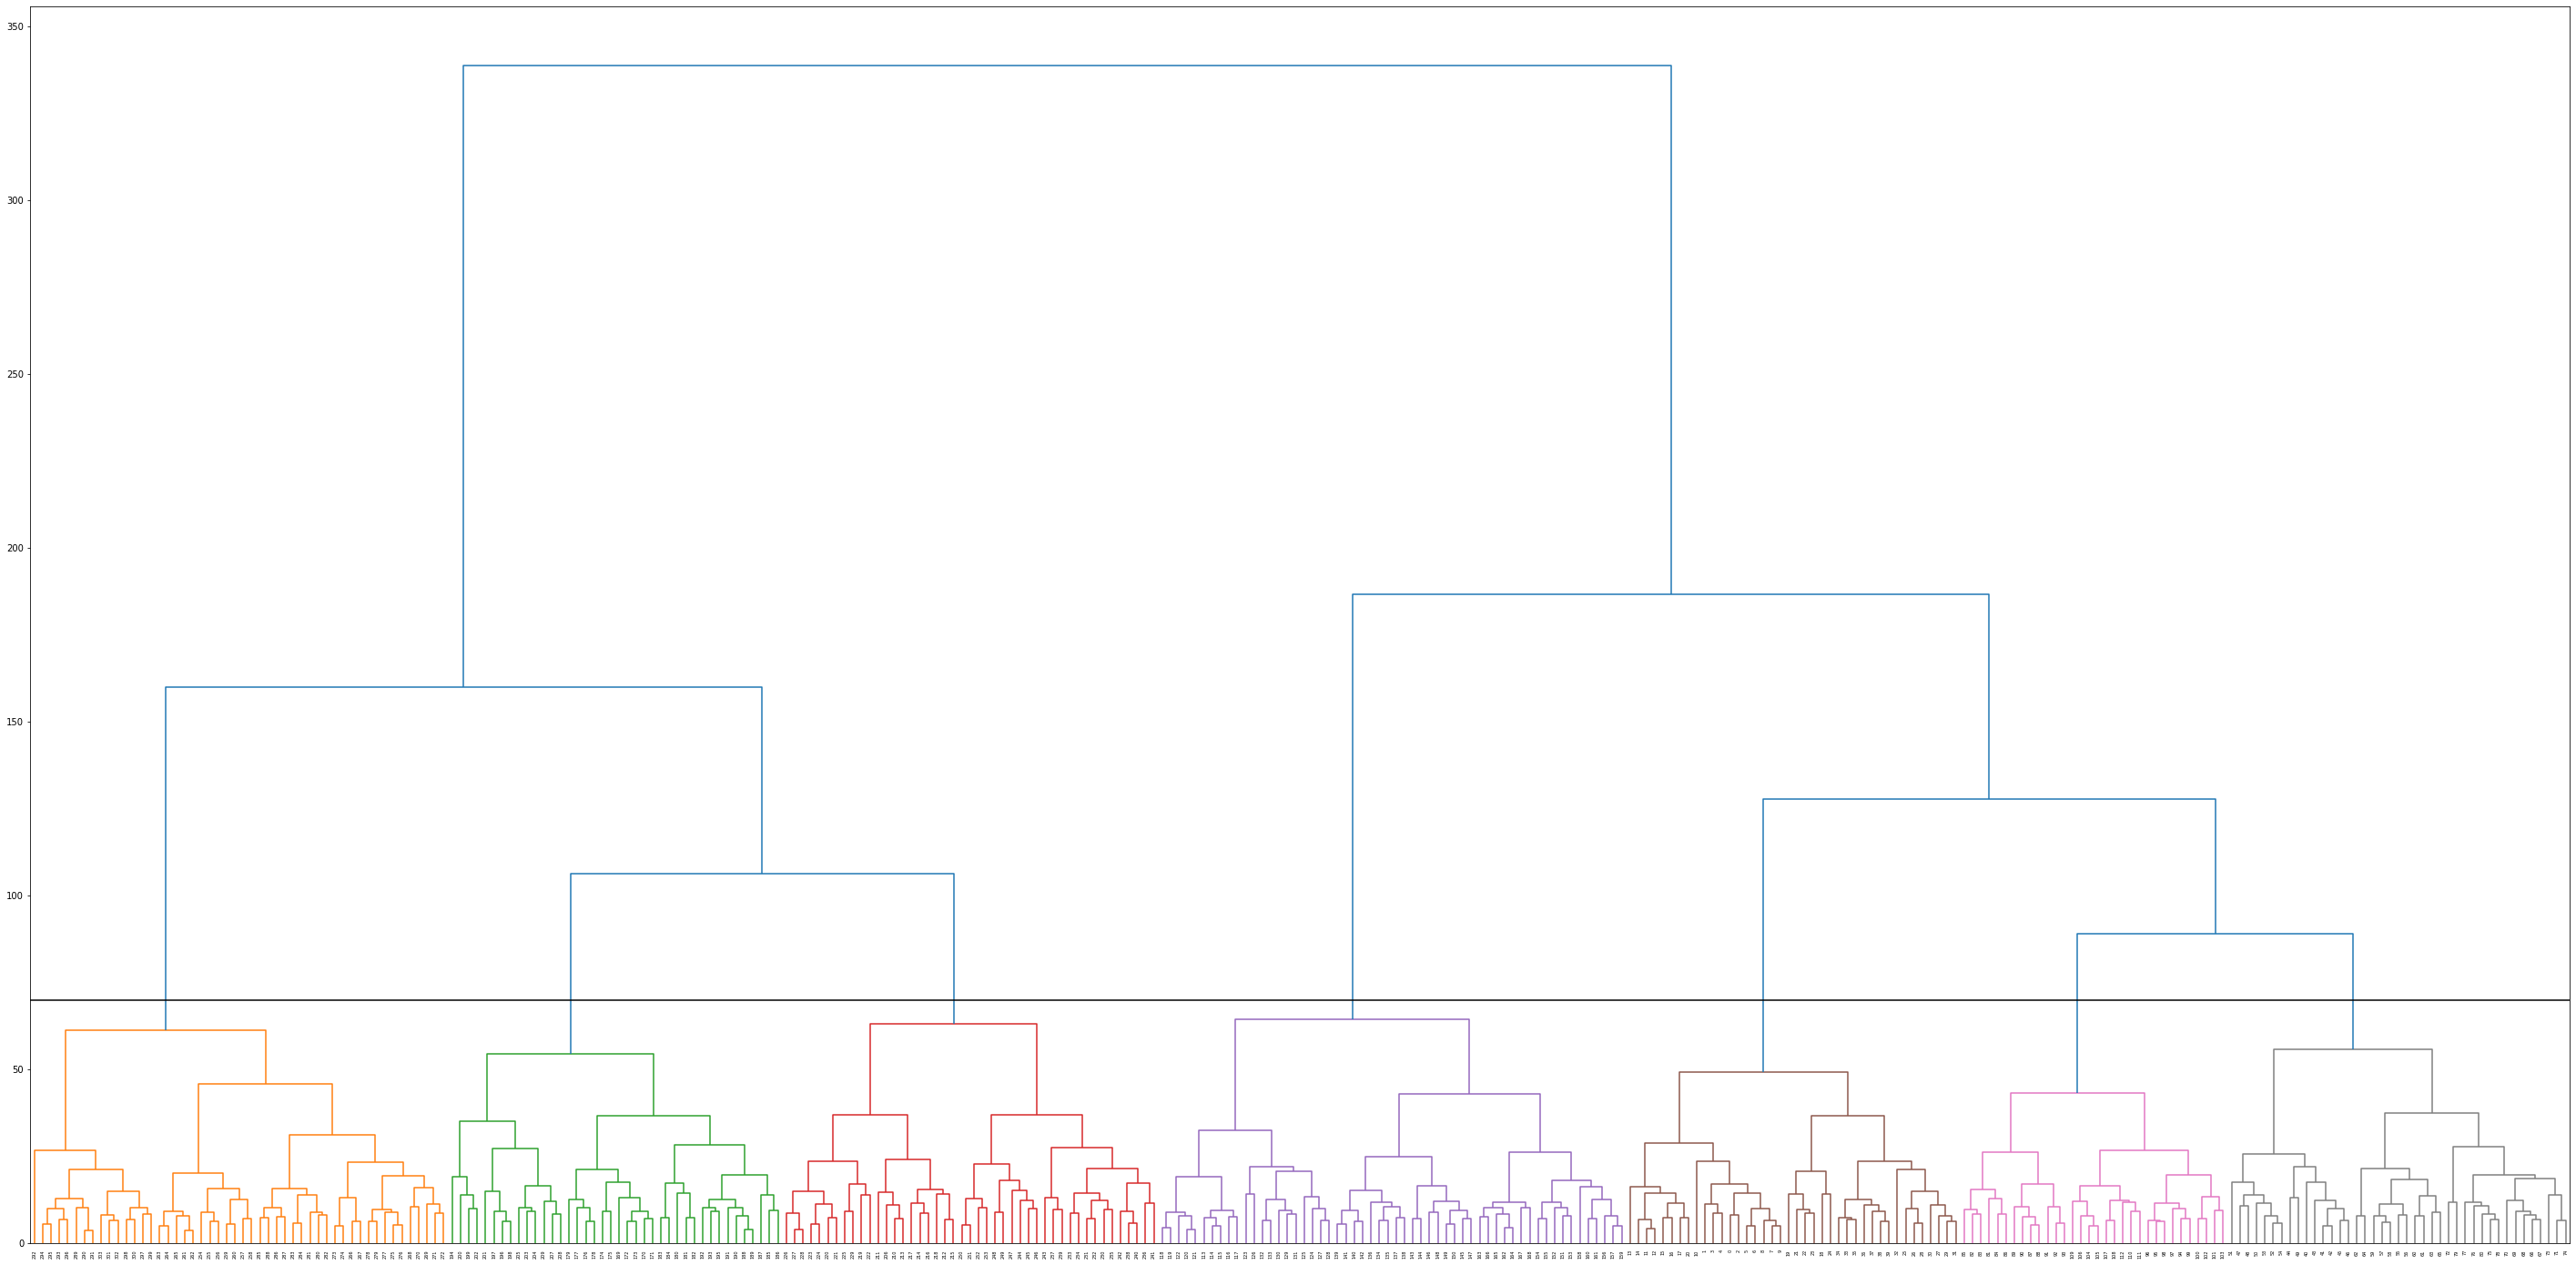

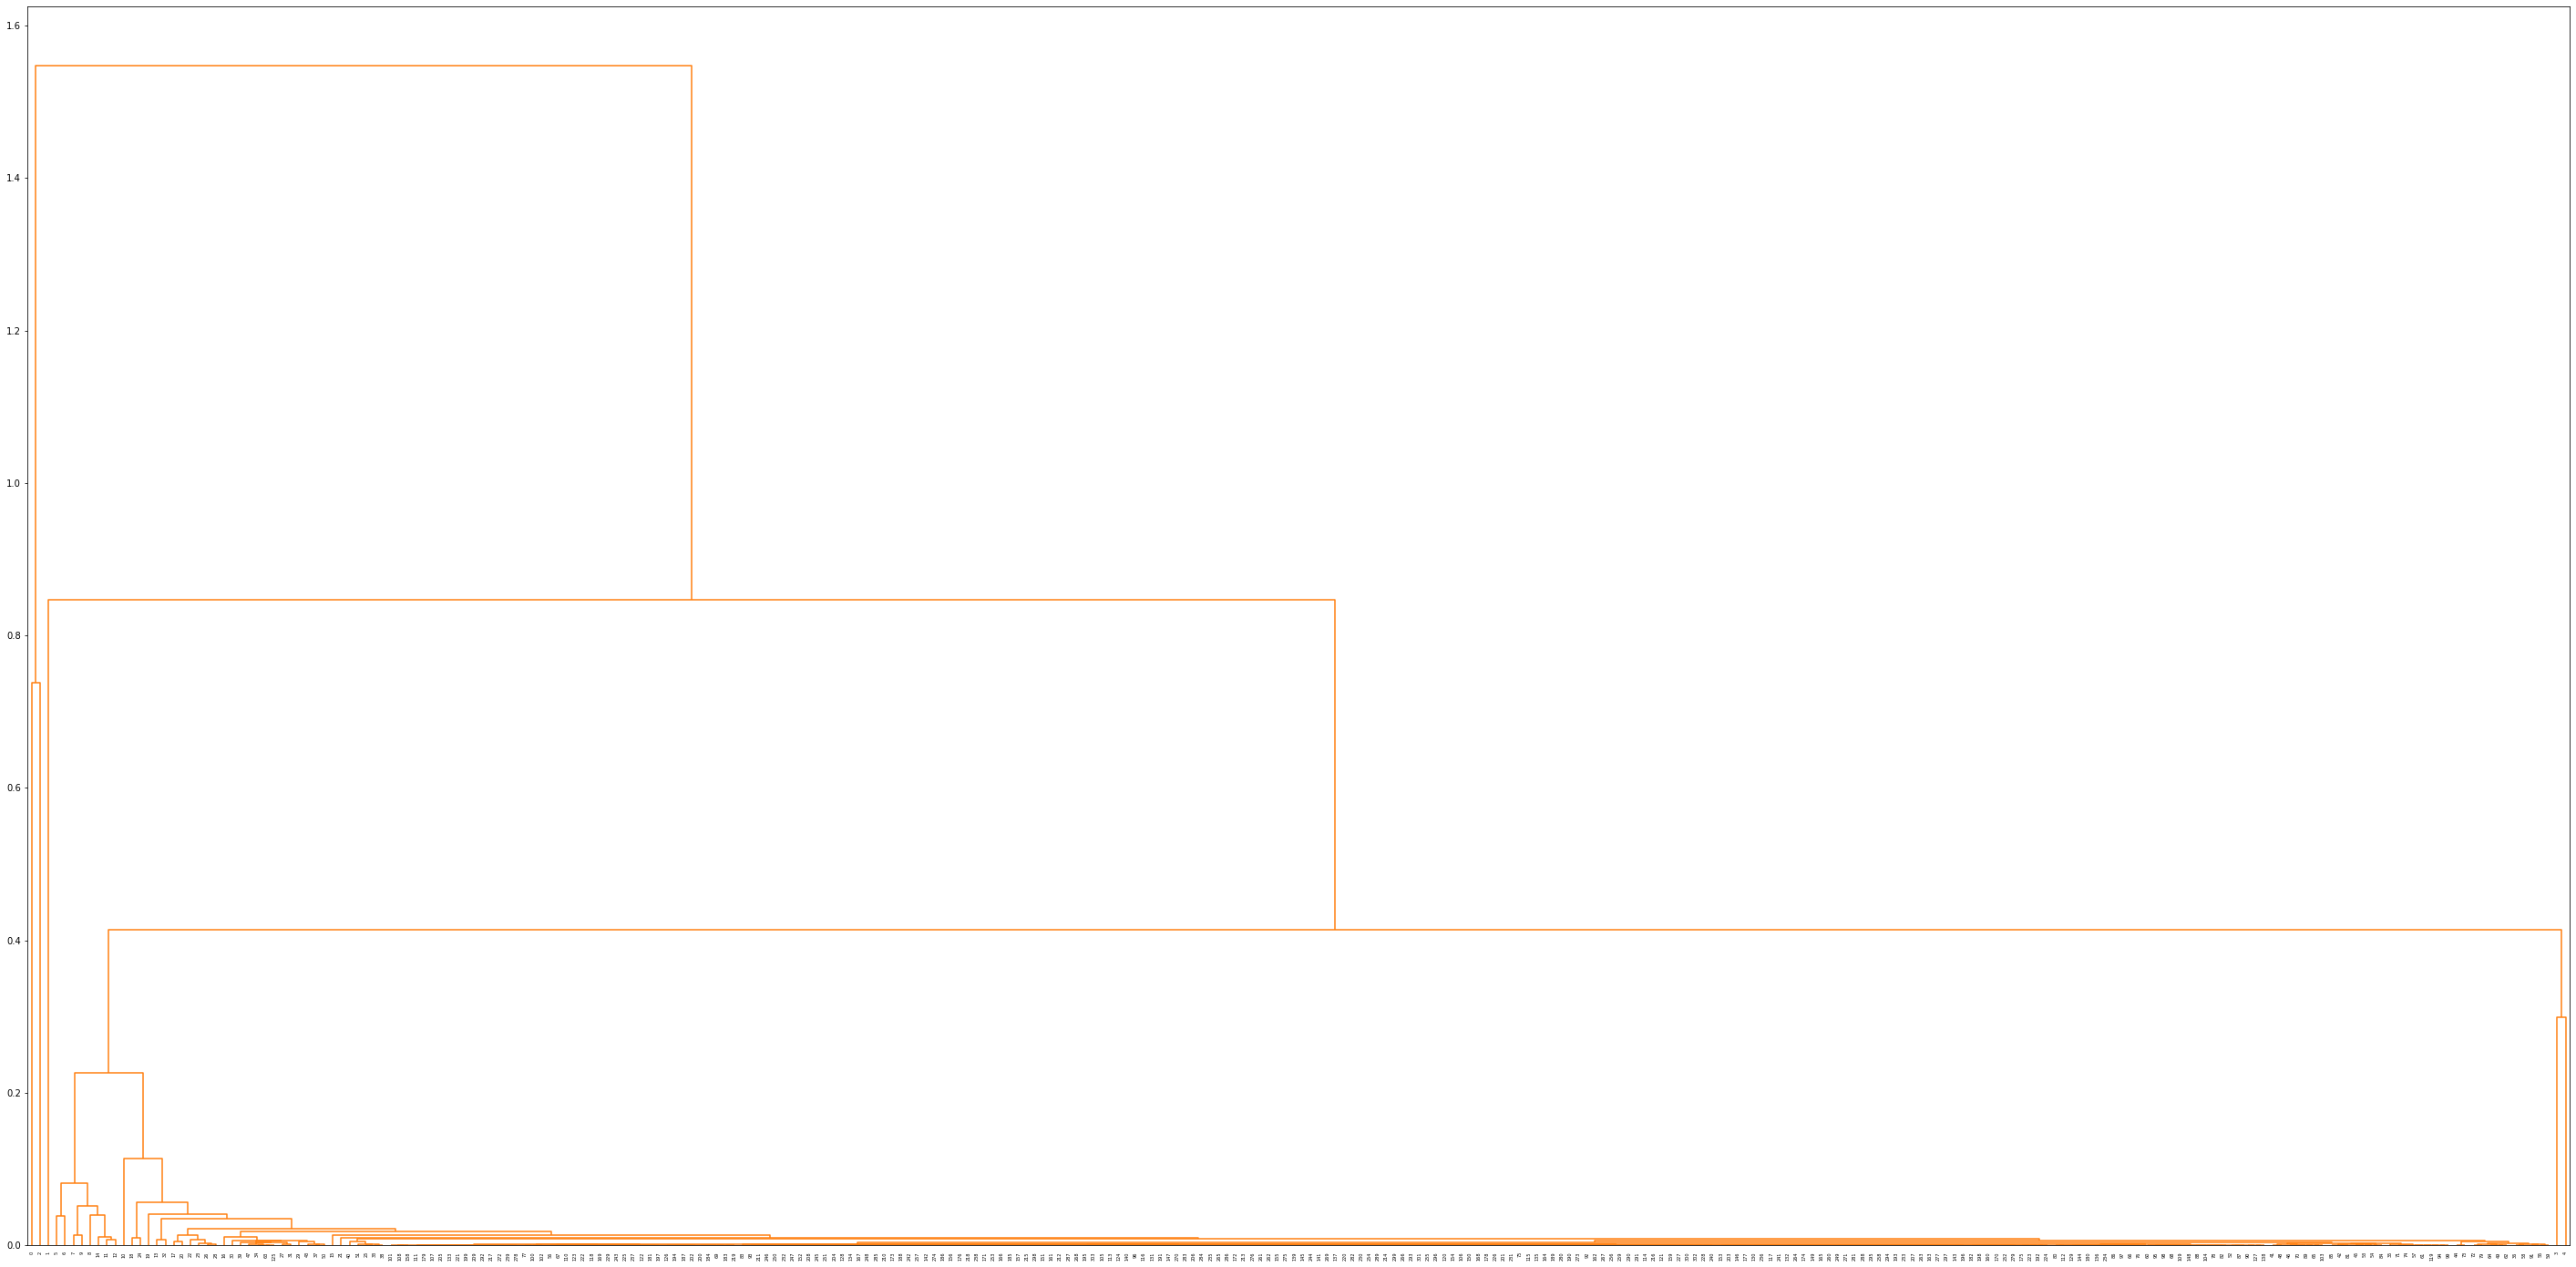

In [24]:
# 1

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

for mtr in ['euclidean', 'minkowski', 'cityblock', 'cosine']:
    Z = linkage(data, metric=mtr, method='complete')
    
    plt.figure(figsize=(50, 25))
    dendrogram(Z, color_threshold=70)
    plt.axhline(y=70, c='k')
    plt.show()

In [ ]:
Z = linkage(data, metric='euclidean', method='complete')

In [ ]:
def plot_elbow(Z, h=10, w=5):
    plt.figure(figsize=(h, w))
    plt.plot(np.array(range(1, np.shape(Z)[0]+1)), 
             Z[:,2][::-1], 
             marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("Merge distance")
    plt.show()

In [ ]:
plot_elbow(Z)

In [26]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
import seaborn as sns

# По числу кластеров
print(fcluster(Z, t = 7, criterion='maxclust'))

data_with_clst = data.copy(deep=True)

# По порогу (высоте дерева)
data_with_clst['hierarchy'] = fcluster(Z, t = 70, criterion='distance')

print('Silhouette: ', silhouette_score(data, list(data_with_clst['hierarchy'])))

[1 7 2 5 6 3 3 3 3 3 4 3 3 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

##### Наиболее удачно кластеризуется при пороге = 70, кол-ве кластеров = 7, метрике для расстояний = 'euclidean'

In [ ]:
# 2

import pylab as pl
from sklearn.neighbors import NearestNeighbors

pl.figure(figsize=(20, 10))
for i, n in enumerate(range(3, 9)):
    model = NearestNeighbors(n_neighbors=n, algorithm="ball_tree")
    model.fit(data)
    dist, _ = model.kneighbors(data, n_neighbors=n, return_distance=True)
    dist = dist[:, -1]
    dist = np.sort(dist)
    
    pl.subplot(2, 3, i+1)
    plt.ylabel('Means distance over {} nearest neighbors'.format(n))
    plt.xlabel('Sorted distances over all pairs')
    pl.plot(dist, c='r')

In [ ]:
from sklearn.cluster import DBSCAN

cl_dbscan = DBSCAN(eps=4.5, min_samples=3, metric='euclidean')

cl_dbscan.fit(data)

data_with_clst['dbscan'] = cl_dbscan.labels_

print('Silhouette: ', silhouette_score(data, cl_dbscan.labels_))

pd.Series(cl_dbscan.labels_).value_counts()

In [ ]:
# 3

from sklearn.cluster import KMeans

cl_kmeans = KMeans(n_clusters = 7,
           init = 'random',
           n_init = 1,
           max_iter = 100, 
           random_state=15434,
          )
cl_kmeans.fit(data)

data_with_clst['kmeans'] = cl_dbscan.labels_


print('Silhouette: ', silhouette_score(data, cl_kmeans.labels_))
print('Inertia: ', cl_kmeans.inertia_)

In [ ]:
inertia = []
for k in range(5, 20):
    Z = KMeans(n_clusters=k, 
               init = 'random',
               n_init = 100,
               max_iter = 1000).fit(data)
    inertia.append(Z.inertia_)

plt.plot(range(5, 20), inertia, 'bo-', marker='s')
plt.xlabel('$k$')
plt.ylabel('Objective function value')
plt.axvline(x=7, c='r')
plt.show()

##### Наилучшее число кластеров (на мой взгляд) = 7

In [27]:
# 4
cl_kmedoids = k_medoids(data, 7, 'euclidean', 100, 0)

data_with_clst['kmedoids'] = pd.Series()
for obj in cl_kmedoids['labels']:
    data_with_clst.loc[obj[1], 'kmedoids'] = obj[0]
    
print('Silhouette: ', silhouette_score(data, [x[0] for x in sorted(cl_kmedoids['labels'], key=lambda a: a[1])]))
print('Inertia: ', cl_kmedoids['inertia'])

Number of iterations to stop changing medoids is 6
Silhouette:  0.5373744625315315
Inertia:  3707.456147859273


<ipython-input-27-85c5f4960afd>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_with_clst['kmedoids'] = pd.Series()


In [ ]:
inertia = []
for k in range(5, 20):
    Z = k_medoids(data, 7, 'euclidean', 100, 0)
    inertia.append(Z['inertia'])

plt.plot(range(5, 20), inertia, 'bo-', marker='s')
plt.xlabel('$k$')
plt.ylabel('Objective function value')
plt.axvline(x=7, c='r')
plt.show()

In [ ]:
# 5

import hdbscan

cl_hdbscan = hdbscan.HDBSCAN(min_cluster_size=14, gen_min_span_tree=True)
cl_hdbscan.fit(data)

data_with_clst['hdbscan'] = cl_kmeans.labels_

print('Silhouette: ', silhouette_score(data, cl_hdbscan.labels_))

pd.Series(cl_hdbscan.labels_).value_counts()

# # 6

##### Далее будут визуализированы все вида кластерных разбиений, из которых будет выбран 1.
(дополнительные метрики оценивания такие как silhouette или inertia и др. выведены после соответствующих кластеризаций)

### Hierarchy clustering 

In [ ]:
sns.pairplot(data_with_clst, hue='hierarchy', plot_kws={'alpha':0.5}, vars=data.columns)
plt.show()

### DBSCAN clustering 

In [ ]:
sns.pairplot(data_with_clst, hue='dbscan', plot_kws={'alpha':0.5}, vars=data.columns)
plt.show()

### KMeans clustering 

In [ ]:
sns.pairplot(data_with_clst, hue='kmeans', plot_kws={'alpha':0.5}, vars=data.columns)
plt.show()

### PAM clustering 

In [ ]:
sns.pairplot(data_with_clst, hue='kmedoids', plot_kws={'alpha':0.5}, vars=data.columns)
plt.show()

### HDBSCAN clustering 

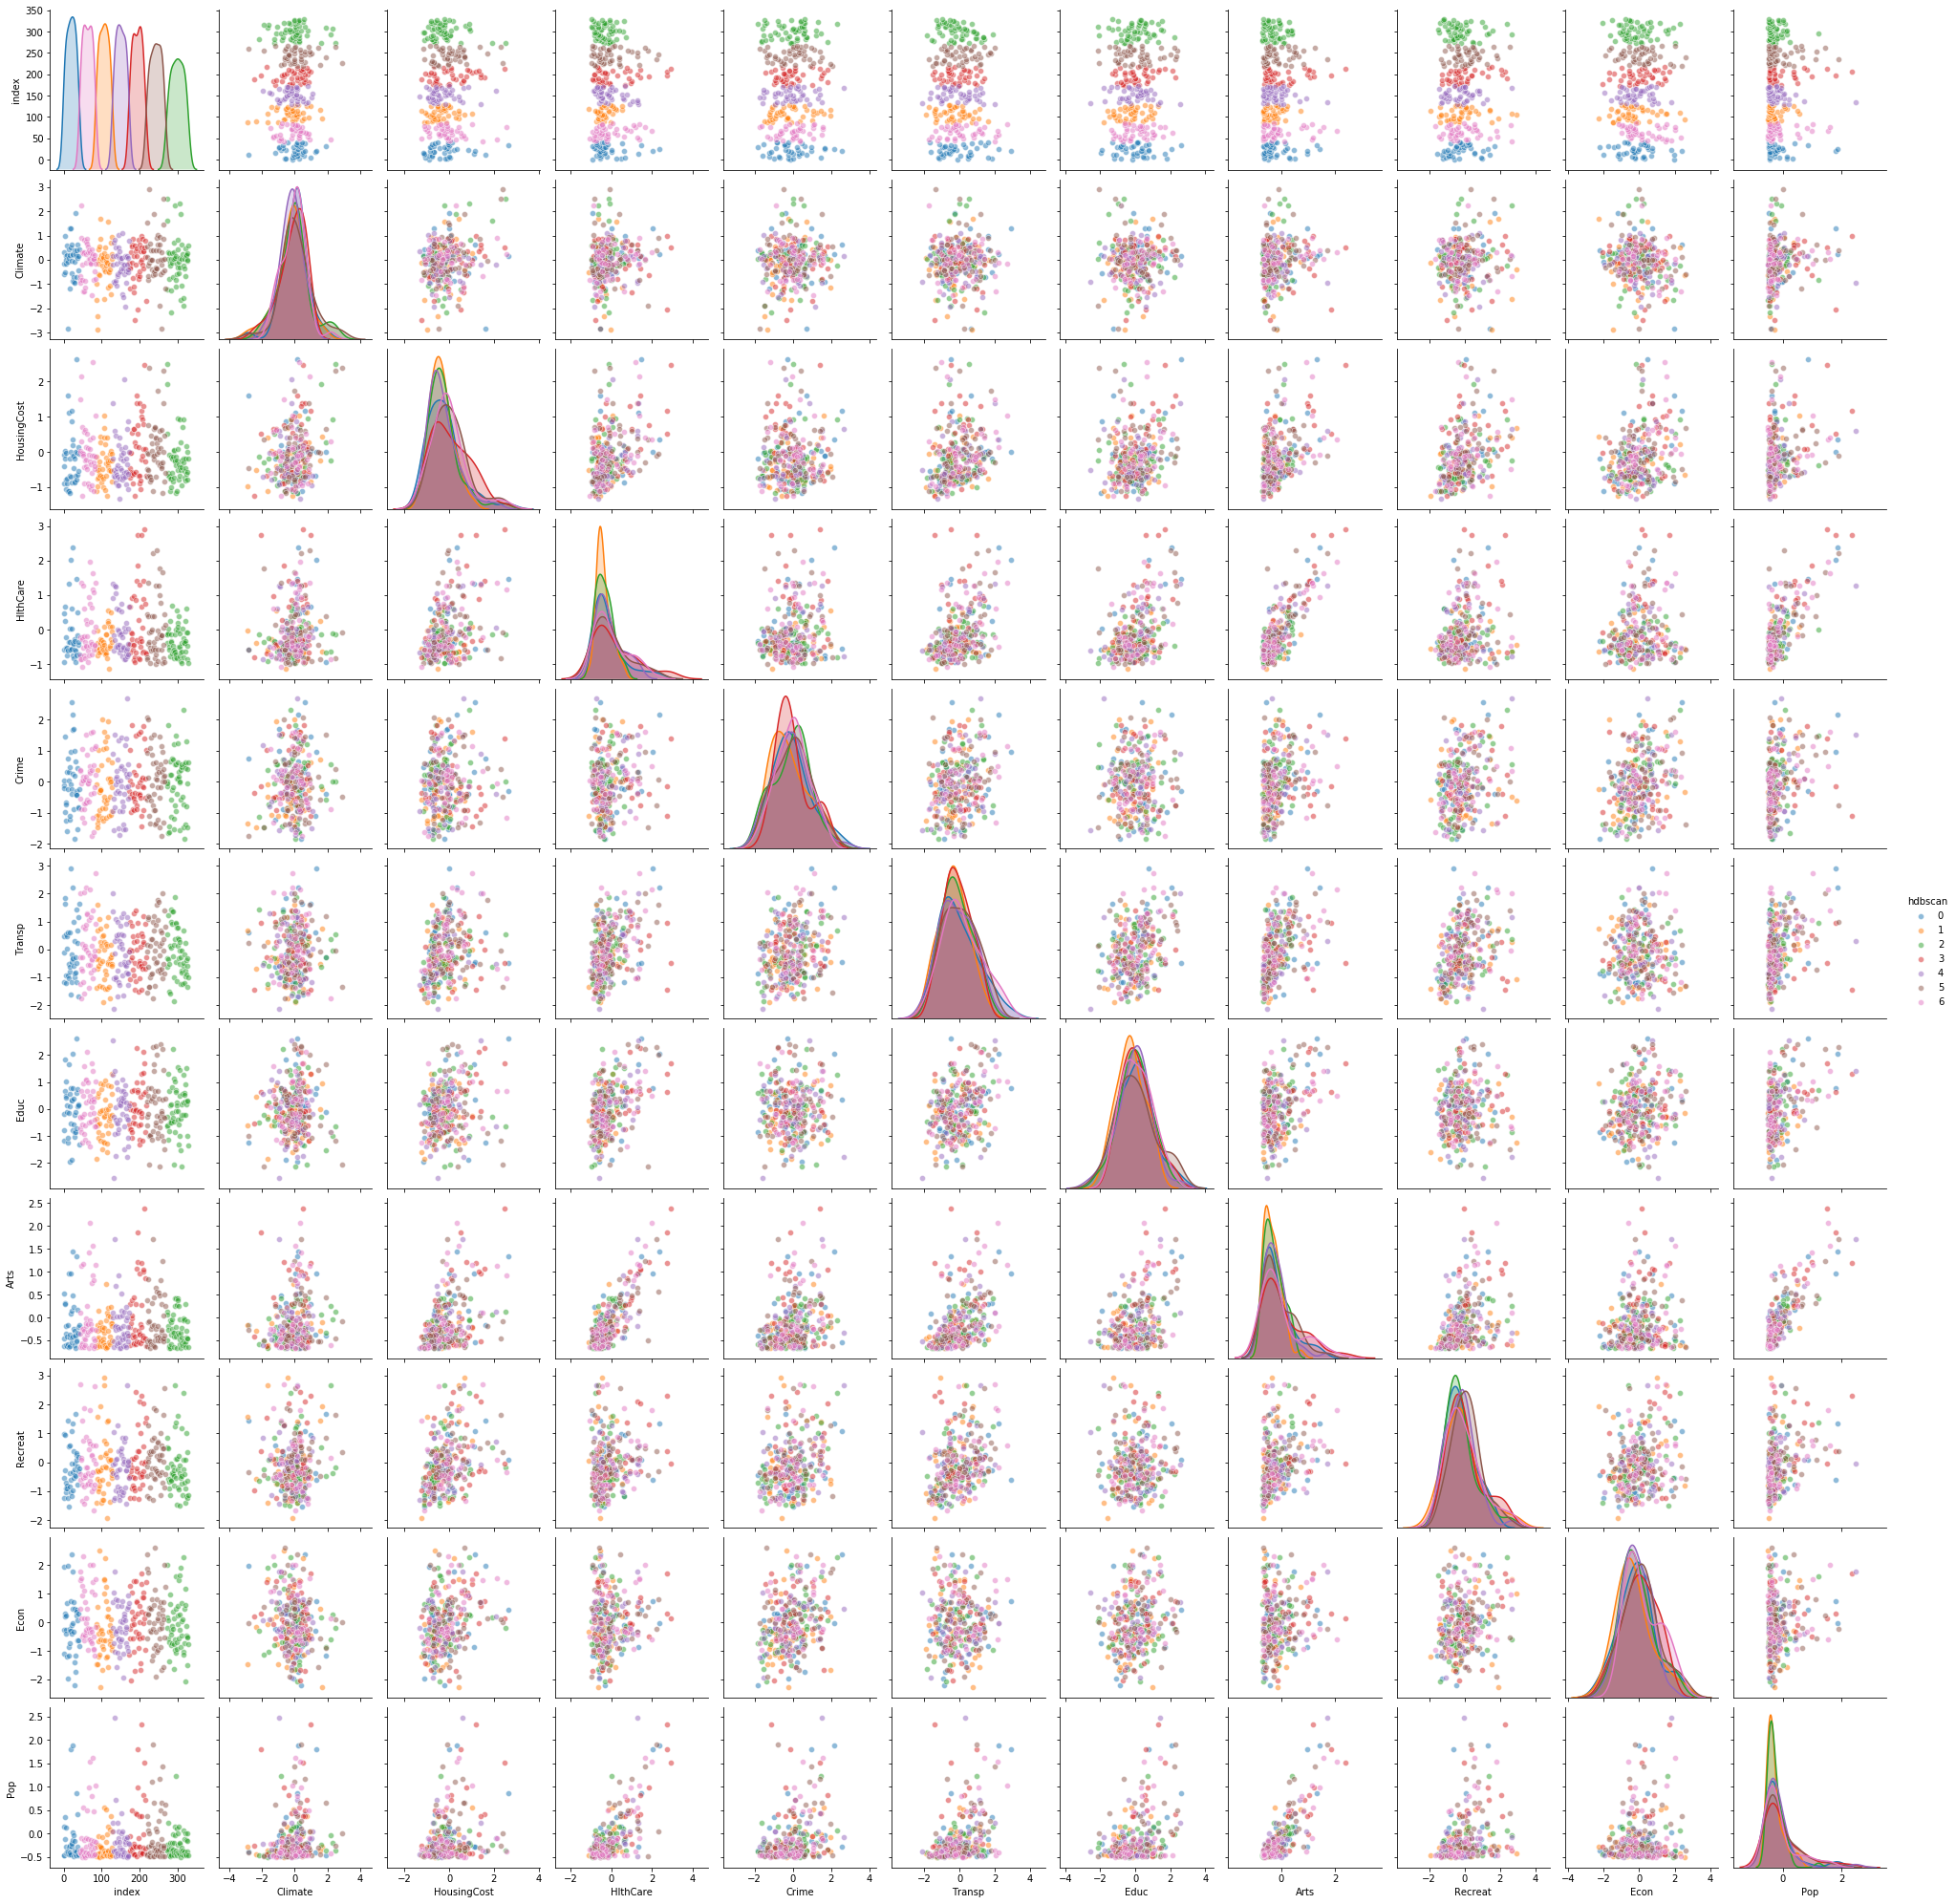

In [383]:
sns.pairplot(data_with_clst, hue='hdbscan', plot_kws={'alpha':0.5}, vars=data.columns)
plt.show()

# # 7

##### Исходя из данных по построенным графикам, сложно сделать однозначный вывод о наиболее удачном разбиении, поэтому стоит обратить на такие критерии, как silhouette и inertia: у PAM модели самая небольшая inertia и silhouette выше, чем 0.5, это показатели свидетельствуют об успешном разбиении, следовательно, возьмем его.

В данной выборке сложно однозначно интерпретировать разбиение по кластерам, ведь если взгялнуть на выше построенные графики, то можно сделать вывод, что в большинстве попарных сравнений, слабо выраженно разделение объектов по группам. Так, например, рассматривая объекты, размещенные на scatterplot в соответствии со значениями признаков Transp и Climate, выделить отдельные кластеры затруднительно.

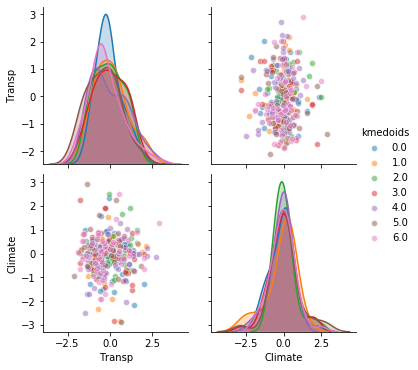

In [35]:
sns.pairplot(data_with_clst, hue='kmedoids', plot_kws={'alpha':0.5}, vars=['Transp', 'Climate'])
plt.show()

In [31]:
obj['Place']

'Richland-Kinnewick-Pasco,WA'

In [28]:
# 8

import folium

data_geo = pd.read_csv('Data.txt', sep=' ')[['Place', 'Long', 'Lat']].loc[[obj[1] for obj in cl_kmedoids['labels']]]
data_geo['clst'] = data_with_clst['kmedoids'].apply(int)

clst_colors = {0: '#b6e890', 1: '#31ccc5', 2: '#ccc531', 3: '#7831cc', 4: '#3185cc', 5: '#37cc31', 6: '#b9a2b9'}

m = folium.Map(
    location=[data_geo['Lat'].mean(), data_geo['Long'].mean()],
    tiles='Stamen Toner',
    zoom_start=4
)

for _, obj in data_geo.iterrows():
    folium.Circle(
        radius=5,
        location=[(obj['Lat']), obj['Long']],
        popup=obj['Place'],
        color=clst_colors[obj['clst']],
    ).add_to(m)
m

##### Самая очевидная особенность распределения объектов кластеров на карте, выражается в сосредоточенности объектов 1 и 5 кластеров (бирюзовый и зеленый: #31ccc5 и #37cc31) ближе к Нью-Йорку и Филадельфии. С другой же стороны, объекты из кластера 3 (сиреневый: #7831cc ) довольно равномерно распределены по всей территории США.

Работу выполнил: Евтеев И. С. 18БИ-1